In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Load the dataset from Excel
data = pd.read_csv('services.csv')
#data.reset_index(inplace = True, drop = True)
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time
0,5,01/08/2016,73,65,finished,person,False,11:17:23,12:15:04,12:22:44,NaN,109,D,00:57:41
1,5,01/08/2016,73,224,finished,company,False,13:10:57,14:16:46,14:17:54,NaN,109,D,01:05:49
2,6,01/08/2016,34,259,finished,person,False,13:36:52,13:48:33,13:51:33,NaN,3,D,00:11:41
3,25,01/08/2016,6,40,finished,person,False,10:58:16,11:25:34,11:25:44,NaN,11,E,00:27:18
4,25,01/08/2016,6,67,finished,person,False,11:54:41,12:34:12,12:34:51,3184.0,11,E,00:39:31


In [ ]:
data = data.sort_values(by = ['date','arrival_time'])
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,client_id,cashier,service_type,waiting_time
182,43,01/08/2016,5,1,finished,person,False,09:59:13,10:00:52,10:06:01,NaN,73,C,00:01:39
183,43,01/08/2016,5,2,finished,person,False,09:59:28,10:06:03,10:11:56,NaN,73,C,00:06:35
97,30,01/08/2016,3,1,finished,person,True,09:59:56,10:05:14,10:08:43,11151.0,144,A,00:05:18
6,30,01/08/2016,2,2,finished,person,False,10:00:14,10:17:13,10:18:42,12449.0,144,C,00:16:59
242,45,01/08/2016,2,3,finished,person,True,10:01:30,10:02:21,10:06:31,8257.0,92,A,00:00:51


In [ ]:
# Convert arrival time, waiting time, and service time to minutes
data['arrival_time'] = pd.to_datetime(data['arrival_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['arrival_time'], format='%H:%M:%S').dt.minute
data['start_time'] = pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['start_time'], format='%H:%M:%S').dt.minute
data['end_time'] = pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['end_time'], format='%H:%M:%S').dt.minute
data['waiting_time'] = pd.to_datetime(data['waiting_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(data['waiting_time'], format='%H:%M:%S').dt.minute
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data['date'] = data['date'].astype(int)
data.drop(columns=['client_id'], inplace=True)

In [ ]:
encoder = LabelEncoder()
data['priority'] = encoder.fit_transform(data['priority'])
data['entity'] = encoder.fit_transform(data['entity'])
data['service_type'] = encoder.fit_transform(data['service_type'])
data['status'] = encoder.fit_transform(data['status'])
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,cashier,service_type,waiting_time
0,5,1470009600000000000,73,65,0,1,0,677,735,742,109,2,57
1,5,1470009600000000000,73,224,0,0,0,790,856,857,109,2,65
2,6,1470009600000000000,34,259,0,1,0,816,828,831,3,2,11
3,25,1470009600000000000,6,40,0,1,0,658,685,685,11,3,27
4,25,1470009600000000000,6,67,0,1,0,714,754,754,11,3,39


In [ ]:
# Define a custom function to calculate queue length
def calculate_queue_length(row, data):
    return data[(data['date'] == row['date']) &
        (data['queue_id'] == row['queue_id']) &
        (data['branch_id'] == row['branch_id']) &
        (data['arrival_time'] < row['start_time'])]['arrival_time'].count()

# Apply the custom function to each row
data['queue_length'] = data.apply(calculate_queue_length, axis=1, data=data)
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,cashier,service_type,waiting_time,queue_length
0,5,1470009600000000000,73,65,0,1,0,677,735,742,109,2,57,1
1,5,1470009600000000000,73,224,0,0,0,790,856,857,109,2,65,2
2,6,1470009600000000000,34,259,0,1,0,816,828,831,3,2,11,1
3,25,1470009600000000000,6,40,0,1,0,658,685,685,11,3,27,1
4,25,1470009600000000000,6,67,0,1,0,714,754,754,11,3,39,2


In [ ]:
# Define the bins for discretizing waiting time
bins = [-1, 5, 10, 20, 30, float('inf')]  # Including float('inf') for values greater than 30 minutes
#bins = [-1,30,float('inf')]
# Define the labels for the discrete intervals
#labels = ['Very Short', 'Short', 'Regular', 'Long', 'Very Long']
labels = [0, 1, 2, 3, 4]
#labels = [0, 1]

# Convert waiting time into discrete intervals
data['waiting_time_category'] = pd.cut(data['waiting_time'], bins=bins, labels=labels)
data.head()

,branch_id,date,queue_id,sequence,status,entity,priority,arrival_time,start_time,end_time,cashier,service_type,waiting_time,queue_length,waiting_time_category
0,5,1470009600000000000,73,65,0,1,0,677,735,742,109,2,57,1,4
1,5,1470009600000000000,73,224,0,0,0,790,856,857,109,2,65,2,4
2,6,1470009600000000000,34,259,0,1,0,816,828,831,3,2,11,1,2
3,25,1470009600000000000,6,40,0,1,0,658,685,685,11,3,27,1,3
4,25,1470009600000000000,6,67,0,1,0,714,754,754,11,3,39,2,4


In [ ]:
class_counts = data['waiting_time_category'].value_counts()
class_counts.head()

,count
waiting_time_category,
0,5792
1,2212
2,2092
4,1593
3,1019


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Assuming you have a pandas DataFrame called 'data' with features and labels
# Let's assume the label column is named 'class'

# Step 3: Split the data into features and labels
X = data.drop('waiting_time_category', axis=1)  # Features
y = data['waiting_time_category']                # Labels

# Step 4: Apply SMOTE only to the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Concatenate the original and synthetic samples
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['waiting_time_category'])], axis=1)

# Now 'resampled_data' contains the resampled dataset with SMOTE applied
resampled_data.head()
data = resampled_data
data.to_csv('resampled_data.csv', index=False)

<Axes: xlabel='waiting_time_category'>

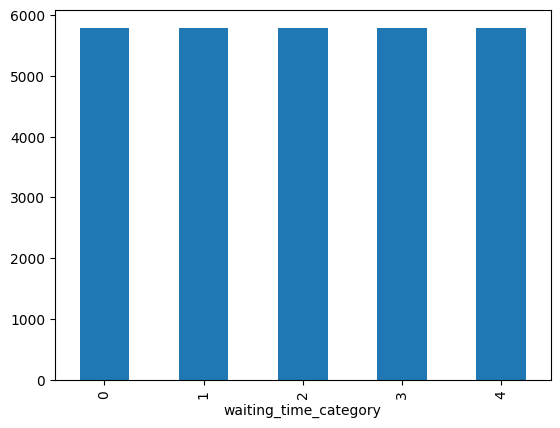

In [ ]:
import pandas as pd


df = resampled_data

# Count the occurrences of each class
class_counts = df['waiting_time_category'].value_counts()

# Plot the bar plot
class_counts.plot(kind='bar')

In [ ]:
# Determine the count of samples in the minority class
minority_class_count = df['waiting_time_category'].value_counts().min()

# Sample the majority classes to match the count of the minority class
balanced_data = []
for class_label in df['waiting_time_category'].unique():
    samples = df[df['waiting_time_category'] == class_label].sample(minority_class_count, replace=False)
    balanced_data.append(samples)

# Concatenate the sampled data from each class
balanced_df = pd.concat(balanced_data)

# Shuffle the DataFrame to randomize the order
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

print(balanced_df['waiting_time_category'].value_counts())
print(balanced_df.head())

0    1019
1    1019
2    1019
3    1019
4    1019
Name: waiting_time_category, dtype: int64
   branch_id                 date  queue_id  sequence  status  entity  \
0         45  1471219200000000000         3       105       0       1   
1         22  1462665600000000000         4        72       1       1   
2         40  1471996800000000000         6        21       0       1   
3         22  1472515200000000000         3       169       1       1   
4         43  1471478400000000000         5        40       0       1   

   priority  arrival_time  start_time  end_time  client_id  cashier  \
0         0           807         824       825        NaN       92   
1         1           659         693       693        NaN       75   
2         0           661         661       664     8606.0      155   
3         0           828         982       982        NaN       75   
4         0           749         751       752        NaN       73   

   service_type  waiting_time  queue_lengt

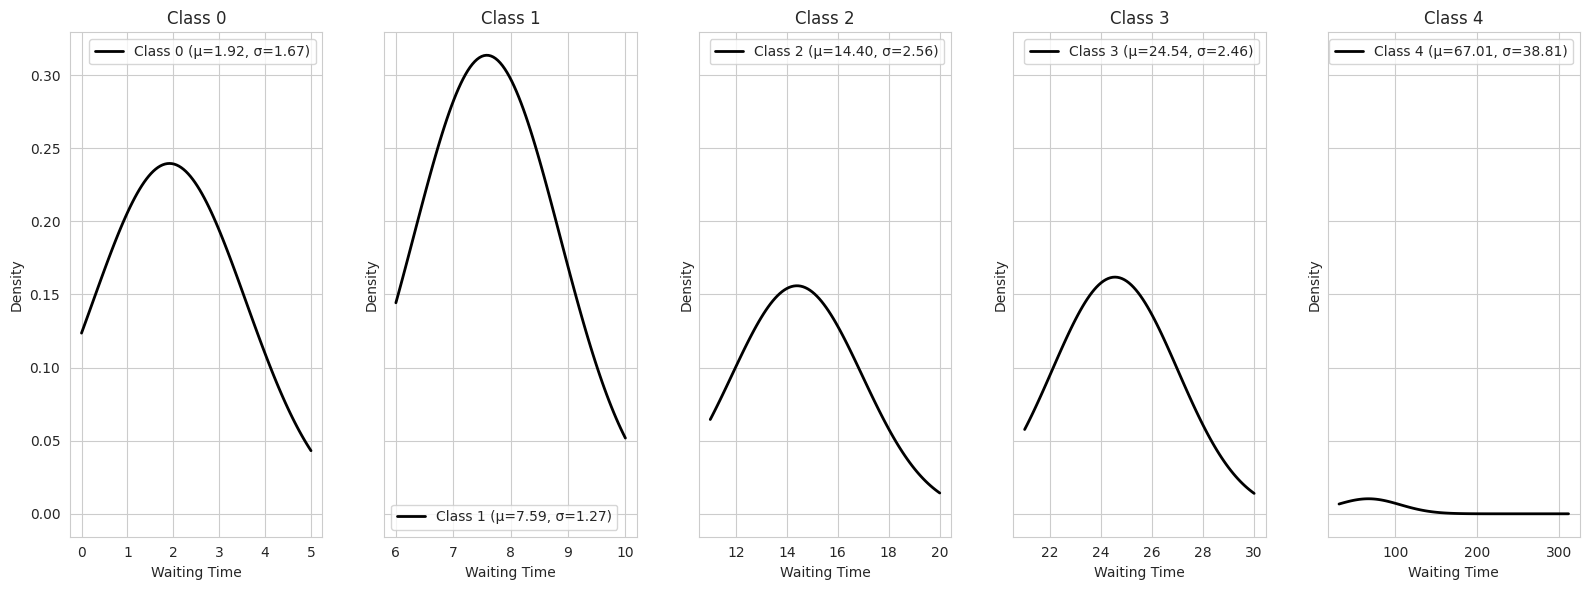

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming 'data' is your DataFrame containing the 'waiting_time_category' column
# Replace 'data' with the actual name of your DataFrame if it's different

# Set the style of seaborn
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(16, 6), sharey=True)

# Plot the Gaussian curve for each class
for i, label in enumerate(labels):
    # Select data for the current class
    class_data = data[data['waiting_time_category'] == label]['waiting_time']

    # Fit Gaussian curve
    mu, std = norm.fit(class_data)

    # Plot Gaussian curve
    xmin, xmax = class_data.min(), class_data.max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[i].plot(x, p, 'k', linewidth=2, label=f'Class {label} (μ={mu:.2f}, σ={std:.2f})')

    axes[i].set_title(f'Class {label}')
    axes[i].set_xlabel('Waiting Time')
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import shapiro

# Assuming 'data' is your DataFrame containing the 'waiting_time_category' column
# Replace 'data' with the actual name of your DataFrame if it's different

# Initialize a dictionary to store p-values for each class
p_values = {}

# Calculate p-value for each class
for label in labels:
    # Select data for the current class
    class_data = data[data['waiting_time_category'] == label]['waiting_time']

    # Perform Shapiro-Wilk test
    _, p_value = shapiro(class_data)

    # Store the p-value
    p_values[label] = p_value

# Print p-values for each class
for label, p_value in p_values.items():
    print(f"Class {label}: p-value = {p_value}")


Class 0: p-value = 0.0
Class 1: p-value = 5.816891379421133e-38
Class 2: p-value = 3.174413972061544e-32
Class 3: p-value = 2.369861953648054e-21
Class 4: p-value = 1.447705265567862e-39


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
#X = data[['branch_id','date','queue_id','sequence','status','entity','priority','arrival_time','cashier','service_type','queue_length']]
X = data[['date','arrival_time','priority','cashier','queue_length']]
y = data['waiting_time_category']

In [ ]:
# 3. Split the Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)

# Print the accuracy of the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy of Best Model:", accuracy_best)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# 4. Train a Classification Model (Random Forest Classifier)
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2,max_depth=None)

# 5. Train the Model
rf_classifier.fit(X_train, y_train)

# 6. Predict Classes
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)


# Plot ROC curve
y_probs = rf_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RF classifier')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.8181975138121547
F1 Score: 0.8184433542434506
True Positives: 855
False Positives: 186
True Negatives: 895
False Negatives: 189


ValueError: multiclass format is not supported

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Train a Classification Model (Random Forest Classifier)
rf_classifier = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, max_depth=None)

# Train the Model
rf_classifier.fit(X_train, y_train)

# Predict Classes
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Print results for each class
for i in range(len(TP)):
    print("Class:", i)
    print("True Positives:", TP[i])
    print("False Positives:", FP[i])
    print("True Negatives:", TN[i])
    print("False Negatives:", FN[i])



Accuracy: 0.7372147915027537
F1 Score: 0.7307664790296612
Class: 0
True Positives: 978
False Positives: 263
True Negatives: 1157
False Negatives: 144
Class: 1
True Positives: 210
False Positives: 172
True Negatives: 1896
False Negatives: 264
Class: 2
True Positives: 272
False Positives: 139
True Negatives: 1982
False Negatives: 149
Class: 3
True Positives: 126
False Positives: 70
True Negatives: 2271
False Negatives: 75
Class: 4
True Positives: 288
False Positives: 24
True Negatives: 2194
False Negatives: 36


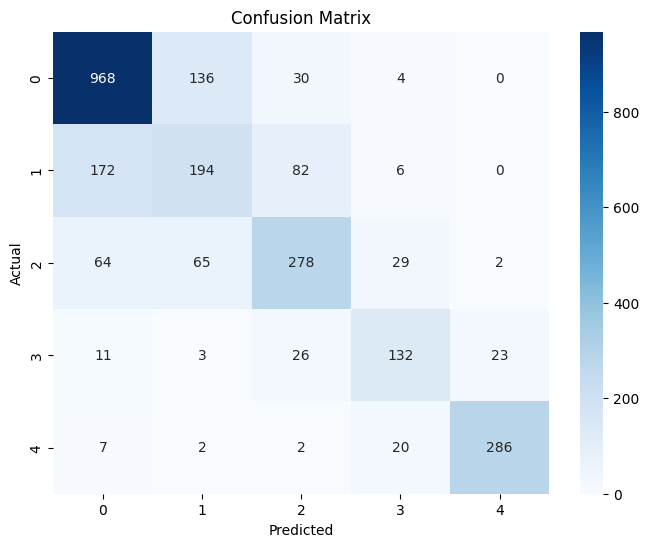

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels (if not already defined)
# class_labels = ["Class 0", "Class 1", ...]

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


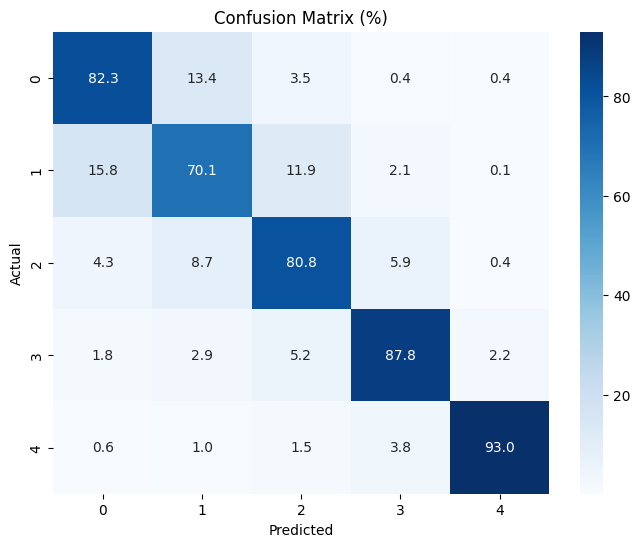

In [ ]:
import numpy as np

# Assuming conf_matrix is your confusion matrix

# Calculate row-wise sums to get total actual instances
row_sums = conf_matrix.sum(axis=1, keepdims=True)

# Calculate percentages
conf_matrix_percent = conf_matrix / row_sums * 100

# Plot confusion matrix heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap="Blues", fmt=".1f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier

# Train a Classification Model (Extra Trees Classifier)
et_classifier = ExtraTreesClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=5, max_depth=None)

# Train the Model
et_classifier.fit(X_train, y_train)

# Predict Classes
y_pred = et_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Print results for each class
for i in range(len(TP)):
    print("Class:", i)
    print("True Positives:", TP[i])
    print("False Positives:", FP[i])
    print("True Negatives:", TN[i])
    print("False Negatives:", FN[i])


Accuracy: 0.826139502762431
F1 Score: 0.8264822774925863
Class: 0
True Positives: 930
False Positives: 329
True Negatives: 4344
False Negatives: 189
Class: 1
True Positives: 860
False Positives: 293
True Negatives: 4273
False Negatives: 366
Class: 2
True Positives: 887
False Positives: 231
True Negatives: 4442
False Negatives: 232
Class: 3
True Positives: 1065
False Positives: 115
True Negatives: 4452
False Negatives: 160
Class: 4
True Positives: 1043
False Positives: 39
True Negatives: 4650
False Negatives: 60


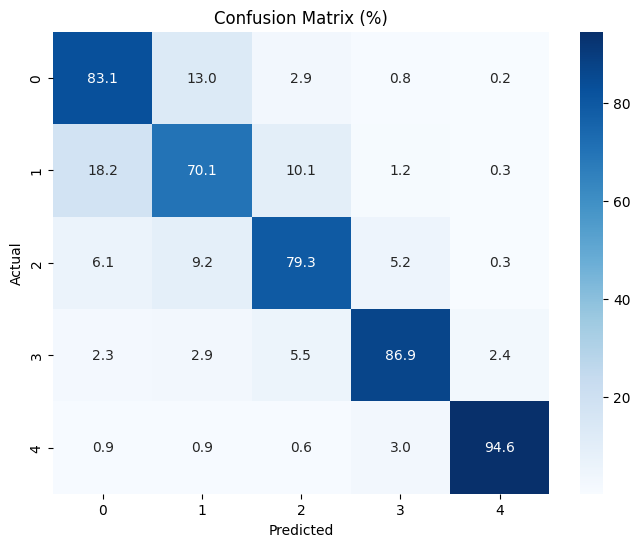

In [ ]:
import numpy as np

# Assuming conf_matrix is your confusion matrix

# Calculate row-wise sums to get total actual instances
row_sums = conf_matrix.sum(axis=1, keepdims=True)

# Calculate percentages
conf_matrix_percent = conf_matrix / row_sums * 100

# Plot confusion matrix heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap="Blues", fmt=".1f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': range(100, 501, 100),
    'learning_rate': [0.1, 0.2, 0.25, 0.3],
    'max_depth': range(2, 11),
    'subsample': [0.5,0.7,0.9,1.0],
    'max_features': [0.1, 0.3, 0.5, 0.8, 1.0]
}

# Create the GBM classifier
gbm_classifier = GradientBoostingClassifier()

# Perform grid search cross-validation
grid_search = GridSearchCV(gbm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM model with specified hyperparameters
gbm_model = GradientBoostingClassifier(loss='deviance', n_estimators=450, learning_rate=0.7, max_depth=7, min_samples_split=2, min_samples_leaf=1)

# Train the model on the training data
gbm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gbm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)


# Plot ROC curve
y_probs = gbm_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM model with specified hyperparameters
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, min_samples_split=2, min_samples_leaf=1)

# Train the model on the training data
gbm_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gbm_model.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Print results for each class
for i in range(len(TP)):
    print("Class:", i)
    print("True Positives:", TP[i])
    print("False Positives:", FP[i])
    print("True Negatives:", TN[i])
    print("False Negatives:", FN[i])


Accuracy: 0.7179386309992132
F1 Score: 0.7118904226931037
Class: 0
True Positives: 973
False Positives: 296
True Negatives: 1108
False Negatives: 165
Class: 1
True Positives: 185
False Positives: 208
True Negatives: 1880
False Negatives: 269
Class: 2
True Positives: 265
False Positives: 136
True Negatives: 1968
False Negatives: 173
Class: 3
True Positives: 122
False Positives: 54
True Negatives: 2293
False Negatives: 73
Class: 4
True Positives: 280
False Positives: 23
True Negatives: 2202
False Negatives: 37


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the XGBoost classifier with specified hyperparameters
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)


# Plot ROC curve
y_probs = xgb_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGB Classifier')
plt.legend(loc='lower right')
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:00:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5830055074744296
F1 Score: 0.49897777817656763
True Positives: 17
False Positives: 14
True Negatives: 1072
False Negatives: 389


ValueError: multiclass format is not supported

In [ ]:
from xgboost import XGBClassifier

# Define the XGBoost classifier with specified hyperparameters
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.3, max_depth=10, min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi: softprob', nthread=4, scale_pos_weight=1, seed=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Print results for each class
for i in range(len(TP)):
    print("Class:", i)
    print("True Positives:", TP[i])
    print("False Positives:", FP[i])
    print("True Negatives:", TN[i])
    print("False Negatives:", FN[i])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:02:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7029897718332022
F1 Score: 0.6994926432548583
Class: 0
True Positives: 938
False Positives: 278
True Negatives: 1126
False Negatives: 200
Class: 1
True Positives: 185
False Positives: 239
True Negatives: 1849
False Negatives: 269
Class: 2
True Positives: 254
False Positives: 151
True Negatives: 1953
False Negatives: 184
Class: 3
True Positives: 125
False Positives: 63
True Negatives: 2284
False Negatives: 70
Class: 4
True Positives: 285
False Positives: 24
True Negatives: 2201
False Negatives: 32


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the KNN classifier with specified hyperparameters
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)


# Plot ROC curve
y_probs = knn_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNN classifier')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.7615676795580111
F1 Score: 0.7616762165708384
True Positives: 840
False Positives: 257
True Negatives: 712
False Negatives: 194


ValueError: multiclass format is not supported

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the KNN classifier with specified hyperparameters
knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=1, n_neighbors=1, p=2,
 weights='uniform')

# Train the model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_model.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Print results for each class
for i in range(len(TP)):
    print("Class:", i)
    print("True Positives:", TP[i])
    print("False Positives:", FP[i])
    print("True Negatives:", TN[i])
    print("False Negatives:", FN[i])


Accuracy: 0.7041699449252558
F1 Score: 0.7050754802519131
Class: 0
True Positives: 894
False Positives: 211
True Negatives: 1193
False Negatives: 244
Class: 1
True Positives: 204
False Positives: 243
True Negatives: 1845
False Negatives: 250
Class: 2
True Positives: 282
False Positives: 170
True Negatives: 1934
False Negatives: 156
Class: 3
True Positives: 128
False Positives: 93
True Negatives: 2254
False Negatives: 67
Class: 4
True Positives: 282
False Positives: 35
True Negatives: 2190
False Negatives: 35


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier  # Changed import statement

# Train a Classification Model (Extra Trees Classifier)
et_classifier = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=1, min_samples_split=2, max_depth=None)  # Changed classifier

# Train the Model
et_classifier.fit(X_train, y_train)

# Predict Classes
y_pred = et_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract TP, FP, TN, FN from confusion matrix for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Print results for each class
for i in range(len(TP)):
    print("Class:", i)
    print("True Positives:", TP[i])
    print("False Positives:", FP[i])
    print("True Negatives:", TN[i])
    print("False Negatives:", FN[i])


Accuracy: 0.8176795580110497
F1 Score: 0.8181424835316026
Class: 0
True Positives: 885
False Positives: 302
True Negatives: 4371
False Negatives: 234
Class: 1
True Positives: 864
False Positives: 358
True Negatives: 4213
False Negatives: 357
Class: 2
True Positives: 860
False Positives: 232
True Negatives: 4436
False Negatives: 264
Class: 3
True Positives: 1087
False Positives: 113
True Negatives: 4448
False Negatives: 144
Class: 4
True Positives: 1040
False Positives: 51
True Negatives: 4644
False Negatives: 57
